# Test against just two classes 

In this notebook we will take in our data from CitiBike and organize down to just one start station and two end neighborhoods. The goal is to test if we can better predict on a question with fewer target classes. 

To do this we will test the Xgboost classifier and use the same variables we have for other trials. 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
import itertools
import matplotlib.pyplot as plt
from citibike_scripts_derrick import show_cf
%matplotlib inline

Create a DF with neighborhoods connected to Stations.

In [2]:
neighborhoods = pd.read_csv('citibike_data/citibike_neighborhoods.csv')

In [3]:
neighborhoods['end station name'] = neighborhoods['stops']
neighborhoods = neighborhoods[['end station name', 'stop_nhbr']]

### Import and Pull only data from a single station start and two destinations. 

In [4]:
for i in range(1,13):
    if i == 1:
        big = pd.read_csv('citibike_data/2018'+ str(i).zfill(2)+'-citibike-tripdata.csv')
        big = pd.merge(big, neighborhoods, on='end station name', how='left')
        big = big[(big['start station id']==490) & ((big['stop_nhbr']=='Upper West Side') 
       |(big['stop_nhbr']=='East Village'))]
        #big = big.sample(frac=.1)
    else:
        temp = pd.read_csv('citibike_data/2018'+ str(i).zfill(2)+'-citibike-tripdata.csv')
        temp = pd.merge(temp, neighborhoods, on='end station name', how='left')
        temp = temp[(temp['start station id']==490) & ((temp['stop_nhbr']=='Upper West Side') 
       |(temp['stop_nhbr']=='East Village'))]
        big = pd.concat([big, temp])

In [5]:
big = big.dropna()

In [6]:
big.usertype = pd.Categorical(big.usertype)
big.usertype = big.usertype.cat.codes

In [7]:
big['starttime'] = pd.to_datetime(big['starttime'])
big['start_month'] = big.starttime.dt.month
big['start_day_of_week'] = big.starttime.dt.dayofweek
big['start_hour'] = big.starttime.dt.hour
big['start_date'] = big.starttime.dt.day

big['starttime'] = big.starttime.dt.date
big['starttime'] = pd.to_datetime(big['starttime'])

In [8]:
weather_df = pd.read_csv('citibike_data/2018_weather.csv')
weather_df['starttime'] = pd.to_datetime(weather_df['date'])
weather_df = weather_df.drop(['max_temp', 'min_temp','departure', 'Hdd', 'cdd', 'new_snow', 'date' ], axis=1)

In [9]:
big = pd.merge(big, weather_df, on='starttime', how='left')

In [10]:
big = big.drop(['tripduration','starttime', 'stoptime','start station name',
                'end station id', 'bikeid', 'start station latitude', 
                'start station longitude', 'end station latitude', 
                'end station longitude','end station name', 'start_date'], axis=1)

In [11]:
df2=big

Split variables from targets: 

In [12]:
labels = df2.stop_nhbr

In [14]:
labels_removed_df = df2.drop('stop_nhbr', axis=1)

Scale data: 

In [23]:
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(labels_removed_df.astype(float))

Split data into training and testing sets. Maintain at least some of each target class in both sets with the 'stratify' argument.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(scaled_df, labels)

Fit xgboost model:

In [30]:
clf = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.7, max_delta_step=0,
       max_depth=4, min_child_weight=5, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [31]:
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.7, max_delta_step=0,
       max_depth=4, min_child_weight=5, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [32]:
training_preds = clf.predict(X_train)

In [33]:
val_preds = clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

Training Accuracy: 86.19%
Validation accuracy: 65.4%


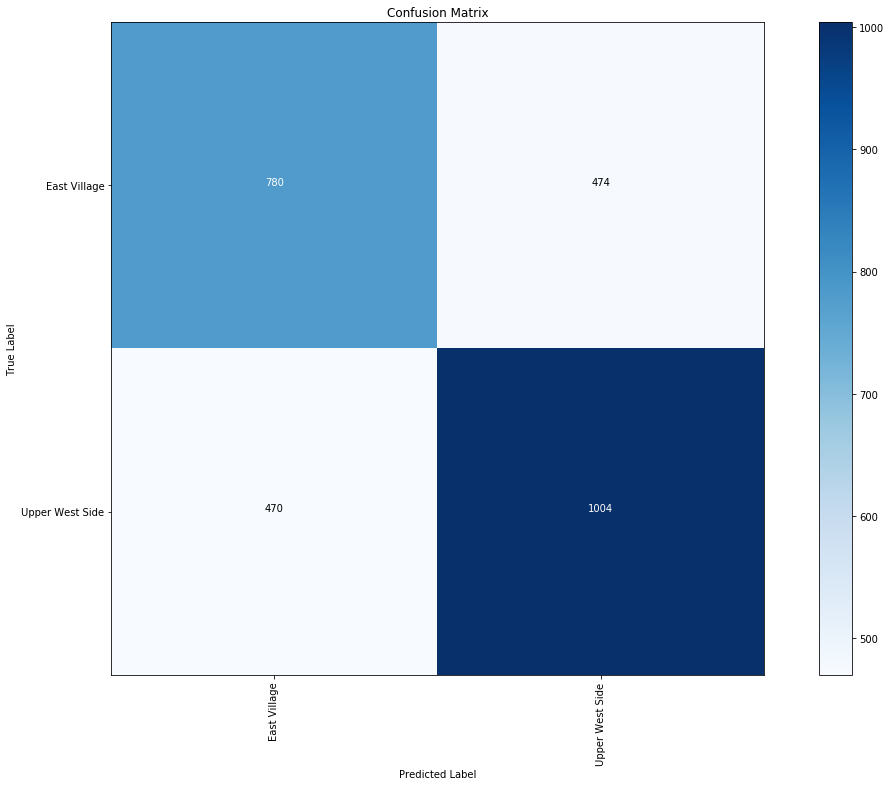

In [34]:
show_cf(y_test, val_preds)

In [21]:
param_grid = {
    "learning_rate": [0.5, 0.7, 0.1],
    'max_depth': [2, 3, 4],
    'min_child_weight': [4, 5],
    'n_estimators': [300, 400, 500],
}

In [22]:
grid_clf = GridSearchCV(clf, param_grid, scoring='accuracy', cv=None, n_jobs=1)
eval_metric = ["auc", 'error']
eval_set = [(X_train, y_train), (X_test, y_test)]
grid_clf.fit(X_train, y_train, eval_set= eval_set, early_stopping_rounds=20)
best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
val_preds = grid_clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

[0]	validation_0-error:0.428763	validation_1-error:0.409091
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 20 rounds.
[1]	validation_0-error:0.423387	validation_1-error:0.421554
[2]	validation_0-error:0.4174	validation_1-error:0.417522
[3]	validation_0-error:0.400782	validation_1-error:0.393695
[4]	validation_0-error:0.40176	validation_1-error:0.393328
[5]	validation_0-error:0.401515	validation_1-error:0.398827
[6]	validation_0-error:0.400415	validation_1-error:0.395161
[7]	validation_0-error:0.40066	validation_1-error:0.396994
[8]	validation_0-error:0.398827	validation_1-error:0.395528
[9]	validation_0-error:0.396383	validation_1-error:0.395161
[10]	validation_0-error:0.395039	validation_1-error:0.395528
[11]	validation_0-error:0.394917	validation_1-error:0.392229
[12]	validation_0-error:0.392595	validation_1-error:0.393328
[13]	validation_0-error:0.387341	validation_1-error:0.396628

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


[56]	validation_0-error:0.356916	validation_1-error:0.371701
[57]	validation_0-error:0.356061	validation_1-error:0.369135
[58]	validation_0-error:0.355327	validation_1-error:0.372434
[59]	validation_0-error:0.355327	validation_1-error:0.373167
[60]	validation_0-error:0.356549	validation_1-error:0.374633
[61]	validation_0-error:0.356183	validation_1-error:0.373167
[62]	validation_0-error:0.35716	validation_1-error:0.3739
[63]	validation_0-error:0.354717	validation_1-error:0.374267
[64]	validation_0-error:0.355572	validation_1-error:0.374267
[65]	validation_0-error:0.355205	validation_1-error:0.375
[66]	validation_0-error:0.355938	validation_1-error:0.370968
[67]	validation_0-error:0.35716	validation_1-error:0.3739
[68]	validation_0-error:0.356183	validation_1-error:0.374633
[69]	validation_0-error:0.355694	validation_1-error:0.373534
[70]	validation_0-error:0.351173	validation_1-error:0.375367
[71]	validation_0-error:0.351906	validation_1-error:0.375
Stopping. Best iteration:
[51]	valid

[12]	validation_0-error:0.392595	validation_1-error:0.393328
[13]	validation_0-error:0.387341	validation_1-error:0.396628
[14]	validation_0-error:0.38563	validation_1-error:0.394428
[15]	validation_0-error:0.385142	validation_1-error:0.396261
[16]	validation_0-error:0.385264	validation_1-error:0.384164
[17]	validation_0-error:0.383798	validation_1-error:0.385997
[18]	validation_0-error:0.378788	validation_1-error:0.377199
[19]	validation_0-error:0.375978	validation_1-error:0.374633
[20]	validation_0-error:0.377688	validation_1-error:0.378666
[21]	validation_0-error:0.378421	validation_1-error:0.378299
[22]	validation_0-error:0.378543	validation_1-error:0.378299
[23]	validation_0-error:0.37891	validation_1-error:0.383065
[24]	validation_0-error:0.377444	validation_1-error:0.380499
[25]	validation_0-error:0.376222	validation_1-error:0.376833
[26]	validation_0-error:0.373778	validation_1-error:0.3761
[27]	validation_0-error:0.375489	validation_1-error:0.379399
[28]	validation_0-error:0.37

[6]	validation_0-error:0.394673	validation_1-error:0.387463
[7]	validation_0-error:0.392351	validation_1-error:0.38893
[8]	validation_0-error:0.392718	validation_1-error:0.387463
[9]	validation_0-error:0.389418	validation_1-error:0.382331
[10]	validation_0-error:0.391007	validation_1-error:0.388196
[11]	validation_0-error:0.388196	validation_1-error:0.388196
[12]	validation_0-error:0.378055	validation_1-error:0.378299
[13]	validation_0-error:0.377077	validation_1-error:0.375367
[14]	validation_0-error:0.375733	validation_1-error:0.375733
[15]	validation_0-error:0.373534	validation_1-error:0.377566
[16]	validation_0-error:0.372923	validation_1-error:0.379399
[17]	validation_0-error:0.37219	validation_1-error:0.380865
[18]	validation_0-error:0.37109	validation_1-error:0.383065
[19]	validation_0-error:0.371701	validation_1-error:0.387097
[20]	validation_0-error:0.370601	validation_1-error:0.384531
[21]	validation_0-error:0.370357	validation_1-error:0.384164
[22]	validation_0-error:0.36999

[28]	validation_0-error:0.364614	validation_1-error:0.372434
[29]	validation_0-error:0.36217	validation_1-error:0.374633
[30]	validation_0-error:0.362781	validation_1-error:0.373534
[31]	validation_0-error:0.360215	validation_1-error:0.375
[32]	validation_0-error:0.35826	validation_1-error:0.373167
[33]	validation_0-error:0.360826	validation_1-error:0.375
[34]	validation_0-error:0.358016	validation_1-error:0.373534
[35]	validation_0-error:0.356549	validation_1-error:0.371334
[36]	validation_0-error:0.355938	validation_1-error:0.370235
[37]	validation_0-error:0.356183	validation_1-error:0.368402
[38]	validation_0-error:0.35545	validation_1-error:0.368402
[39]	validation_0-error:0.354717	validation_1-error:0.367302
[40]	validation_0-error:0.353861	validation_1-error:0.367669
[41]	validation_0-error:0.354106	validation_1-error:0.363636
[42]	validation_0-error:0.354594	validation_1-error:0.364736
[43]	validation_0-error:0.354839	validation_1-error:0.368402
[44]	validation_0-error:0.354472	

[60]	validation_0-error:0.35826	validation_1-error:0.369868
[61]	validation_0-error:0.357893	validation_1-error:0.373534
[62]	validation_0-error:0.357649	validation_1-error:0.371701
[63]	validation_0-error:0.357649	validation_1-error:0.370968
[64]	validation_0-error:0.357282	validation_1-error:0.369135
[65]	validation_0-error:0.35716	validation_1-error:0.371701
[66]	validation_0-error:0.35716	validation_1-error:0.371701
[67]	validation_0-error:0.355083	validation_1-error:0.369501
[68]	validation_0-error:0.353983	validation_1-error:0.369135
[69]	validation_0-error:0.353617	validation_1-error:0.370235
[70]	validation_0-error:0.353495	validation_1-error:0.371334
[71]	validation_0-error:0.355205	validation_1-error:0.368035
[72]	validation_0-error:0.354839	validation_1-error:0.369501
[73]	validation_0-error:0.354472	validation_1-error:0.366569
[74]	validation_0-error:0.353495	validation_1-error:0.365469
[75]	validation_0-error:0.353006	validation_1-error:0.368402
[76]	validation_0-error:0.3

Will train until validation_1-error hasn't improved in 20 rounds.
[1]	validation_0-error:0.424976	validation_1-error:0.42412
[2]	validation_0-error:0.419966	validation_1-error:0.420821
[3]	validation_0-error:0.421554	validation_1-error:0.420455
[4]	validation_0-error:0.422043	validation_1-error:0.421188
[5]	validation_0-error:0.394306	validation_1-error:0.404326
[6]	validation_0-error:0.388685	validation_1-error:0.396994
[7]	validation_0-error:0.387219	validation_1-error:0.396261
[8]	validation_0-error:0.386241	validation_1-error:0.396994
[9]	validation_0-error:0.402493	validation_1-error:0.408724
[10]	validation_0-error:0.400538	validation_1-error:0.406158
[11]	validation_0-error:0.393695	validation_1-error:0.397727
[12]	validation_0-error:0.391007	validation_1-error:0.396628
[13]	validation_0-error:0.39174	validation_1-error:0.391862
[14]	validation_0-error:0.384897	validation_1-error:0.387463
[15]	validation_0-error:0.380376	validation_1-error:0.392229
[16]	validation_0-error:0.3802

[29]	validation_0-error:0.374022	validation_1-error:0.375
[30]	validation_0-error:0.373656	validation_1-error:0.375733
[31]	validation_0-error:0.370846	validation_1-error:0.377199
[32]	validation_0-error:0.372923	validation_1-error:0.375
[33]	validation_0-error:0.373778	validation_1-error:0.374633
[34]	validation_0-error:0.371945	validation_1-error:0.370235
[35]	validation_0-error:0.371334	validation_1-error:0.374267
[36]	validation_0-error:0.371823	validation_1-error:0.377199
[37]	validation_0-error:0.37219	validation_1-error:0.375
[38]	validation_0-error:0.369135	validation_1-error:0.371701
[39]	validation_0-error:0.368157	validation_1-error:0.370601
[40]	validation_0-error:0.365714	validation_1-error:0.368402
[41]	validation_0-error:0.364492	validation_1-error:0.369868
[42]	validation_0-error:0.365225	validation_1-error:0.369501
[43]	validation_0-error:0.365103	validation_1-error:0.370235
[44]	validation_0-error:0.365591	validation_1-error:0.375
[45]	validation_0-error:0.365591	vali

[66]	validation_0-error:0.355205	validation_1-error:0.361804
[67]	validation_0-error:0.354472	validation_1-error:0.362537
[68]	validation_0-error:0.354472	validation_1-error:0.36217
[69]	validation_0-error:0.353739	validation_1-error:0.36217
[70]	validation_0-error:0.351417	validation_1-error:0.36217
[71]	validation_0-error:0.35154	validation_1-error:0.355938
[72]	validation_0-error:0.350806	validation_1-error:0.358871
[73]	validation_0-error:0.349462	validation_1-error:0.361437
[74]	validation_0-error:0.347874	validation_1-error:0.361437
[75]	validation_0-error:0.347752	validation_1-error:0.361804
[76]	validation_0-error:0.348729	validation_1-error:0.362903
[77]	validation_0-error:0.348729	validation_1-error:0.36217
[78]	validation_0-error:0.34934	validation_1-error:0.360704
[79]	validation_0-error:0.348363	validation_1-error:0.362537
[80]	validation_0-error:0.347263	validation_1-error:0.36107
[81]	validation_0-error:0.346896	validation_1-error:0.361437
[82]	validation_0-error:0.34714

Will train until validation_1-error hasn't improved in 20 rounds.
[1]	validation_0-error:0.423387	validation_1-error:0.421554
[2]	validation_0-error:0.4174	validation_1-error:0.417522
[3]	validation_0-error:0.400782	validation_1-error:0.393695
[4]	validation_0-error:0.40176	validation_1-error:0.393328
[5]	validation_0-error:0.401515	validation_1-error:0.398827
[6]	validation_0-error:0.400415	validation_1-error:0.395161
[7]	validation_0-error:0.40066	validation_1-error:0.396994
[8]	validation_0-error:0.398949	validation_1-error:0.396261
[9]	validation_0-error:0.396505	validation_1-error:0.395894
[10]	validation_0-error:0.396383	validation_1-error:0.395894
[11]	validation_0-error:0.395283	validation_1-error:0.392962
[12]	validation_0-error:0.394917	validation_1-error:0.393695
[13]	validation_0-error:0.389907	validation_1-error:0.396261
[14]	validation_0-error:0.390152	validation_1-error:0.398094
[15]	validation_0-error:0.388563	validation_1-error:0.400293
[16]	validation_0-error:0.391373

[37]	validation_0-error:0.363514	validation_1-error:0.373167
[38]	validation_0-error:0.365836	validation_1-error:0.373534
[39]	validation_0-error:0.363759	validation_1-error:0.369135
[40]	validation_0-error:0.36217	validation_1-error:0.368768
[41]	validation_0-error:0.362659	validation_1-error:0.368035
[42]	validation_0-error:0.361804	validation_1-error:0.372067
[43]	validation_0-error:0.360948	validation_1-error:0.371334
[44]	validation_0-error:0.360459	validation_1-error:0.369868
[45]	validation_0-error:0.360337	validation_1-error:0.370968
[46]	validation_0-error:0.360093	validation_1-error:0.370601
[47]	validation_0-error:0.360459	validation_1-error:0.368035
[48]	validation_0-error:0.360948	validation_1-error:0.368402
[49]	validation_0-error:0.361804	validation_1-error:0.368768
[50]	validation_0-error:0.359604	validation_1-error:0.371334
[51]	validation_0-error:0.357893	validation_1-error:0.369135
[52]	validation_0-error:0.358504	validation_1-error:0.365469
[53]	validation_0-error:0

[76]	validation_0-error:0.338343	validation_1-error:0.366202
[77]	validation_0-error:0.338587	validation_1-error:0.36437
[78]	validation_0-error:0.339565	validation_1-error:0.364736
[79]	validation_0-error:0.340787	validation_1-error:0.364003
[80]	validation_0-error:0.34152	validation_1-error:0.363636
[81]	validation_0-error:0.339565	validation_1-error:0.361804
[82]	validation_0-error:0.338832	validation_1-error:0.365836
[83]	validation_0-error:0.338343	validation_1-error:0.366569
[84]	validation_0-error:0.337732	validation_1-error:0.366202
[85]	validation_0-error:0.337488	validation_1-error:0.366202
[86]	validation_0-error:0.336755	validation_1-error:0.366935
[87]	validation_0-error:0.336877	validation_1-error:0.366935
[88]	validation_0-error:0.336999	validation_1-error:0.36437
[89]	validation_0-error:0.336877	validation_1-error:0.365103
[90]	validation_0-error:0.337977	validation_1-error:0.368035
[91]	validation_0-error:0.33871	validation_1-error:0.369135
[92]	validation_0-error:0.33

[105]	validation_0-error:0.300831	validation_1-error:0.354839
[106]	validation_0-error:0.298387	validation_1-error:0.354472
[107]	validation_0-error:0.298876	validation_1-error:0.353006
[108]	validation_0-error:0.298387	validation_1-error:0.353739
[109]	validation_0-error:0.298631	validation_1-error:0.354839
[110]	validation_0-error:0.298754	validation_1-error:0.353372
[111]	validation_0-error:0.29912	validation_1-error:0.354472
[112]	validation_0-error:0.298265	validation_1-error:0.355572
[113]	validation_0-error:0.298265	validation_1-error:0.355572
[114]	validation_0-error:0.297776	validation_1-error:0.354839
Stopping. Best iteration:
[94]	validation_0-error:0.305596	validation_1-error:0.350073

[0]	validation_0-error:0.414223	validation_1-error:0.418622
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 20 rounds.
[1]	validation_0-error:0.412023	validation_1-error:0.411657
[2]	validati

[8]	validation_0-error:0.374511	validation_1-error:0.382331
[9]	validation_0-error:0.368768	validation_1-error:0.377933
[10]	validation_0-error:0.366569	validation_1-error:0.379765
[11]	validation_0-error:0.365958	validation_1-error:0.376466
[12]	validation_0-error:0.362414	validation_1-error:0.374633
[13]	validation_0-error:0.363514	validation_1-error:0.377566
[14]	validation_0-error:0.363636	validation_1-error:0.378666
[15]	validation_0-error:0.360826	validation_1-error:0.378299
[16]	validation_0-error:0.358627	validation_1-error:0.375367
[17]	validation_0-error:0.356916	validation_1-error:0.375367
[18]	validation_0-error:0.358138	validation_1-error:0.375367
[19]	validation_0-error:0.357771	validation_1-error:0.3761
[20]	validation_0-error:0.356916	validation_1-error:0.370601
[21]	validation_0-error:0.354228	validation_1-error:0.370968
[22]	validation_0-error:0.351906	validation_1-error:0.368035
[23]	validation_0-error:0.351906	validation_1-error:0.365469
[24]	validation_0-error:0.35

[24]	validation_0-error:0.337854	validation_1-error:0.365836
[25]	validation_0-error:0.338099	validation_1-error:0.365469
[26]	validation_0-error:0.33651	validation_1-error:0.365103
[27]	validation_0-error:0.3337	validation_1-error:0.359238
[28]	validation_0-error:0.332845	validation_1-error:0.356305
[29]	validation_0-error:0.331989	validation_1-error:0.354839
[30]	validation_0-error:0.332478	validation_1-error:0.352639
[31]	validation_0-error:0.329423	validation_1-error:0.351906
[32]	validation_0-error:0.329668	validation_1-error:0.354839
[33]	validation_0-error:0.327346	validation_1-error:0.353006
[34]	validation_0-error:0.328079	validation_1-error:0.355205
[35]	validation_0-error:0.327835	validation_1-error:0.356305
[36]	validation_0-error:0.32588	validation_1-error:0.354106
[37]	validation_0-error:0.32588	validation_1-error:0.357405
[38]	validation_0-error:0.322581	validation_1-error:0.358138
[39]	validation_0-error:0.32197	validation_1-error:0.355938
[40]	validation_0-error:0.3191

[46]	validation_0-error:0.328568	validation_1-error:0.36217
[47]	validation_0-error:0.328935	validation_1-error:0.364736
[48]	validation_0-error:0.328201	validation_1-error:0.361804
[49]	validation_0-error:0.327957	validation_1-error:0.356305
[50]	validation_0-error:0.326857	validation_1-error:0.356672
[51]	validation_0-error:0.32759	validation_1-error:0.360337
[52]	validation_0-error:0.326002	validation_1-error:0.358871
[53]	validation_0-error:0.327468	validation_1-error:0.358871
[54]	validation_0-error:0.327346	validation_1-error:0.357771
[55]	validation_0-error:0.326979	validation_1-error:0.358138
[56]	validation_0-error:0.326979	validation_1-error:0.355205
[57]	validation_0-error:0.32368	validation_1-error:0.357771
[58]	validation_0-error:0.322947	validation_1-error:0.355938
[59]	validation_0-error:0.320626	validation_1-error:0.357038
[60]	validation_0-error:0.321725	validation_1-error:0.355938
[61]	validation_0-error:0.321237	validation_1-error:0.357771
[62]	validation_0-error:0.3

[6]	validation_0-error:0.370723	validation_1-error:0.385997
[7]	validation_0-error:0.370112	validation_1-error:0.38563
[8]	validation_0-error:0.368402	validation_1-error:0.372067
[9]	validation_0-error:0.365103	validation_1-error:0.369135
[10]	validation_0-error:0.358016	validation_1-error:0.369868
[11]	validation_0-error:0.352273	validation_1-error:0.370601
[12]	validation_0-error:0.35435	validation_1-error:0.375
[13]	validation_0-error:0.349951	validation_1-error:0.3739
[14]	validation_0-error:0.345186	validation_1-error:0.371334
[15]	validation_0-error:0.343109	validation_1-error:0.372067
[16]	validation_0-error:0.338954	validation_1-error:0.364003
[17]	validation_0-error:0.340787	validation_1-error:0.368768
[18]	validation_0-error:0.337977	validation_1-error:0.367669
[19]	validation_0-error:0.342742	validation_1-error:0.369135
[20]	validation_0-error:0.343719	validation_1-error:0.367669
[21]	validation_0-error:0.343597	validation_1-error:0.366569
[22]	validation_0-error:0.343231	va

[84]	validation_0-error:0.307185	validation_1-error:0.358871
[85]	validation_0-error:0.305352	validation_1-error:0.358871
[86]	validation_0-error:0.304619	validation_1-error:0.356672
[87]	validation_0-error:0.304497	validation_1-error:0.360704
Stopping. Best iteration:
[67]	validation_0-error:0.316471	validation_1-error:0.353372

[0]	validation_0-error:0.414223	validation_1-error:0.418622
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 20 rounds.
[1]	validation_0-error:0.412023	validation_1-error:0.411657
[2]	validation_0-error:0.404448	validation_1-error:0.406525
[3]	validation_0-error:0.394428	validation_1-error:0.404692
[4]	validation_0-error:0.38502	validation_1-error:0.394428
[5]	validation_0-error:0.378177	validation_1-error:0.390029
[6]	validation_0-error:0.371823	validation_1-error:0.381965
[7]	validation_0-error:0.372923	validation_1-error:0.383431
[8]	validation_0-error:0.367

[60]	validation_0-error:0.309873	validation_1-error:0.358138
[61]	validation_0-error:0.30914	validation_1-error:0.354839
[62]	validation_0-error:0.306207	validation_1-error:0.350806
[63]	validation_0-error:0.306452	validation_1-error:0.349707
[64]	validation_0-error:0.306574	validation_1-error:0.35154
[65]	validation_0-error:0.305474	validation_1-error:0.35154
[66]	validation_0-error:0.307063	validation_1-error:0.35154
[67]	validation_0-error:0.30694	validation_1-error:0.351173
[68]	validation_0-error:0.306085	validation_1-error:0.350073
[69]	validation_0-error:0.304374	validation_1-error:0.348607
[70]	validation_0-error:0.303886	validation_1-error:0.345308
[71]	validation_0-error:0.303153	validation_1-error:0.348607
[72]	validation_0-error:0.302419	validation_1-error:0.347141
[73]	validation_0-error:0.302419	validation_1-error:0.347874
[74]	validation_0-error:0.300709	validation_1-error:0.347507
[75]	validation_0-error:0.300098	validation_1-error:0.351173
[76]	validation_0-error:0.298

[8]	validation_0-error:0.367302	validation_1-error:0.379399
[9]	validation_0-error:0.364492	validation_1-error:0.375733
[10]	validation_0-error:0.360948	validation_1-error:0.378299
[11]	validation_0-error:0.360826	validation_1-error:0.379765
[12]	validation_0-error:0.357038	validation_1-error:0.3761
[13]	validation_0-error:0.355572	validation_1-error:0.370601
[14]	validation_0-error:0.354594	validation_1-error:0.365836
[15]	validation_0-error:0.350684	validation_1-error:0.366202
[16]	validation_0-error:0.350684	validation_1-error:0.368768
[17]	validation_0-error:0.354106	validation_1-error:0.368035
[18]	validation_0-error:0.351906	validation_1-error:0.368035
[19]	validation_0-error:0.343597	validation_1-error:0.368402
[20]	validation_0-error:0.338832	validation_1-error:0.359238
[21]	validation_0-error:0.339321	validation_1-error:0.358504
[22]	validation_0-error:0.335777	validation_1-error:0.358504
[23]	validation_0-error:0.336022	validation_1-error:0.357771
[24]	validation_0-error:0.33

[76]	validation_0-error:0.298876	validation_1-error:0.349707
[77]	validation_0-error:0.300342	validation_1-error:0.353739
[78]	validation_0-error:0.300587	validation_1-error:0.353006
[79]	validation_0-error:0.300464	validation_1-error:0.354839
[80]	validation_0-error:0.297776	validation_1-error:0.352639
[81]	validation_0-error:0.297165	validation_1-error:0.35154
[82]	validation_0-error:0.297776	validation_1-error:0.354106
[83]	validation_0-error:0.296921	validation_1-error:0.353739
[84]	validation_0-error:0.296065	validation_1-error:0.355205
[85]	validation_0-error:0.295577	validation_1-error:0.355572
[86]	validation_0-error:0.294966	validation_1-error:0.355938
[87]	validation_0-error:0.294966	validation_1-error:0.357038
[88]	validation_0-error:0.295088	validation_1-error:0.356305
[89]	validation_0-error:0.295821	validation_1-error:0.355205
[90]	validation_0-error:0.29521	validation_1-error:0.355572
Stopping. Best iteration:
[70]	validation_0-error:0.303886	validation_1-error:0.345308


[24]	validation_0-error:0.333822	validation_1-error:0.355205
[25]	validation_0-error:0.331501	validation_1-error:0.352639
[26]	validation_0-error:0.331501	validation_1-error:0.353006
[27]	validation_0-error:0.332356	validation_1-error:0.351906
[28]	validation_0-error:0.331012	validation_1-error:0.352639
[29]	validation_0-error:0.327835	validation_1-error:0.354472
[30]	validation_0-error:0.327957	validation_1-error:0.352639
[31]	validation_0-error:0.328201	validation_1-error:0.353372
[32]	validation_0-error:0.327468	validation_1-error:0.353739
[33]	validation_0-error:0.327713	validation_1-error:0.353006
[34]	validation_0-error:0.324658	validation_1-error:0.356672
[35]	validation_0-error:0.323192	validation_1-error:0.356305
[36]	validation_0-error:0.32368	validation_1-error:0.357771
[37]	validation_0-error:0.324902	validation_1-error:0.357771
[38]	validation_0-error:0.325391	validation_1-error:0.350073
[39]	validation_0-error:0.325269	validation_1-error:0.350073
[40]	validation_0-error:0

[0]	validation_0-error:0.408602	validation_1-error:0.397361
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 20 rounds.
[1]	validation_0-error:0.384042	validation_1-error:0.383798
[2]	validation_0-error:0.37109	validation_1-error:0.378299
[3]	validation_0-error:0.374756	validation_1-error:0.378299
[4]	validation_0-error:0.367669	validation_1-error:0.377566
[5]	validation_0-error:0.363392	validation_1-error:0.3761
[6]	validation_0-error:0.360582	validation_1-error:0.379399
[7]	validation_0-error:0.355205	validation_1-error:0.375367
[8]	validation_0-error:0.354839	validation_1-error:0.377933
[9]	validation_0-error:0.348607	validation_1-error:0.371701
[10]	validation_0-error:0.344575	validation_1-error:0.366569
[11]	validation_0-error:0.343964	validation_1-error:0.365469
[12]	validation_0-error:0.342253	validation_1-error:0.365469
[13]	validation_0-error:0.343475	validation_1-error:0.36107

[6]	validation_0-error:0.346896	validation_1-error:0.368035
[7]	validation_0-error:0.344575	validation_1-error:0.366569
[8]	validation_0-error:0.34653	validation_1-error:0.368402
[9]	validation_0-error:0.341887	validation_1-error:0.364003
[10]	validation_0-error:0.338954	validation_1-error:0.368035
[11]	validation_0-error:0.33651	validation_1-error:0.364003
[12]	validation_0-error:0.334311	validation_1-error:0.361804
[13]	validation_0-error:0.330279	validation_1-error:0.365836
[14]	validation_0-error:0.330401	validation_1-error:0.364003
[15]	validation_0-error:0.326735	validation_1-error:0.354472
[16]	validation_0-error:0.325513	validation_1-error:0.361804
[17]	validation_0-error:0.323314	validation_1-error:0.362537
[18]	validation_0-error:0.323558	validation_1-error:0.36217
[19]	validation_0-error:0.32087	validation_1-error:0.360337
[20]	validation_0-error:0.318426	validation_1-error:0.359971
[21]	validation_0-error:0.315494	validation_1-error:0.36107
[22]	validation_0-error:0.313905	

[5]	validation_0-error:0.36608	validation_1-error:0.376833
[6]	validation_0-error:0.364125	validation_1-error:0.381232
[7]	validation_0-error:0.357893	validation_1-error:0.3739
[8]	validation_0-error:0.353861	validation_1-error:0.3761
[9]	validation_0-error:0.350195	validation_1-error:0.372067
[10]	validation_0-error:0.342131	validation_1-error:0.366569
[11]	validation_0-error:0.339076	validation_1-error:0.364736
[12]	validation_0-error:0.341276	validation_1-error:0.366202
[13]	validation_0-error:0.339443	validation_1-error:0.364003
[14]	validation_0-error:0.337366	validation_1-error:0.365469
[15]	validation_0-error:0.336144	validation_1-error:0.365836
[16]	validation_0-error:0.336266	validation_1-error:0.365836
[17]	validation_0-error:0.331134	validation_1-error:0.365103
[18]	validation_0-error:0.326979	validation_1-error:0.359604
[19]	validation_0-error:0.326369	validation_1-error:0.352273
[20]	validation_0-error:0.323192	validation_1-error:0.354106
[21]	validation_0-error:0.323925	v

[27]	validation_0-error:0.321114	validation_1-error:0.351173
[28]	validation_0-error:0.321237	validation_1-error:0.353006
[29]	validation_0-error:0.319404	validation_1-error:0.351906
[30]	validation_0-error:0.320381	validation_1-error:0.353739
[31]	validation_0-error:0.315249	validation_1-error:0.352273
[32]	validation_0-error:0.31195	validation_1-error:0.351173
[33]	validation_0-error:0.312317	validation_1-error:0.34934
[34]	validation_0-error:0.309384	validation_1-error:0.346408
[35]	validation_0-error:0.307674	validation_1-error:0.352639
[36]	validation_0-error:0.307796	validation_1-error:0.353739
[37]	validation_0-error:0.307307	validation_1-error:0.354839
[38]	validation_0-error:0.306696	validation_1-error:0.355938
[39]	validation_0-error:0.30694	validation_1-error:0.355938
[40]	validation_0-error:0.30804	validation_1-error:0.354472
[41]	validation_0-error:0.306696	validation_1-error:0.34824
[42]	validation_0-error:0.305352	validation_1-error:0.35044
[43]	validation_0-error:0.3018

[36]	validation_0-error:0.297654	validation_1-error:0.348607
[37]	validation_0-error:0.297898	validation_1-error:0.343475
[38]	validation_0-error:0.29741	validation_1-error:0.346041
[39]	validation_0-error:0.29631	validation_1-error:0.35044
[40]	validation_0-error:0.299487	validation_1-error:0.351906
[41]	validation_0-error:0.298265	validation_1-error:0.353006
[42]	validation_0-error:0.296676	validation_1-error:0.35044
[43]	validation_0-error:0.295455	validation_1-error:0.351906
[44]	validation_0-error:0.296188	validation_1-error:0.352273
[45]	validation_0-error:0.295332	validation_1-error:0.352273
[46]	validation_0-error:0.294721	validation_1-error:0.353739
[47]	validation_0-error:0.29411	validation_1-error:0.353739
[48]	validation_0-error:0.292522	validation_1-error:0.351173
[49]	validation_0-error:0.290567	validation_1-error:0.351906
[50]	validation_0-error:0.28739	validation_1-error:0.34934
[51]	validation_0-error:0.286413	validation_1-error:0.348974
[52]	validation_0-error:0.28641

[1]	validation_0-error:0.371823	validation_1-error:0.381965
[2]	validation_0-error:0.364247	validation_1-error:0.376833
[3]	validation_0-error:0.354839	validation_1-error:0.3761
[4]	validation_0-error:0.348607	validation_1-error:0.371334
[5]	validation_0-error:0.351051	validation_1-error:0.36327
[6]	validation_0-error:0.34653	validation_1-error:0.36217
[7]	validation_0-error:0.342864	validation_1-error:0.359238
[8]	validation_0-error:0.336999	validation_1-error:0.358504
[9]	validation_0-error:0.334555	validation_1-error:0.358138
[10]	validation_0-error:0.32979	validation_1-error:0.363636
[11]	validation_0-error:0.329912	validation_1-error:0.362903
[12]	validation_0-error:0.326002	validation_1-error:0.36437
[13]	validation_0-error:0.321847	validation_1-error:0.360337
[14]	validation_0-error:0.322336	validation_1-error:0.352639
[15]	validation_0-error:0.325513	validation_1-error:0.355938
[16]	validation_0-error:0.323803	validation_1-error:0.351906
[17]	validation_0-error:0.321847	validat

[48]	validation_0-error:0.302297	validation_1-error:0.36217
[49]	validation_0-error:0.301686	validation_1-error:0.363636
[50]	validation_0-error:0.302297	validation_1-error:0.36327
[51]	validation_0-error:0.300098	validation_1-error:0.36327
[52]	validation_0-error:0.298509	validation_1-error:0.366935
[53]	validation_0-error:0.296799	validation_1-error:0.368035
[54]	validation_0-error:0.29521	validation_1-error:0.368402
[55]	validation_0-error:0.294599	validation_1-error:0.364736
[56]	validation_0-error:0.292766	validation_1-error:0.366935
Stopping. Best iteration:
[36]	validation_0-error:0.309262	validation_1-error:0.356305

[0]	validation_0-error:0.413245	validation_1-error:0.402493
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 20 rounds.
[1]	validation_0-error:0.389663	validation_1-error:0.389663
[2]	validation_0-error:0.385875	validation_1-error:0.392229
[3]	validation_0-error:0.3

[75]	validation_0-error:0.266129	validation_1-error:0.347507
[76]	validation_0-error:0.264663	validation_1-error:0.344575
[77]	validation_0-error:0.264907	validation_1-error:0.343842
[78]	validation_0-error:0.265152	validation_1-error:0.343842
[79]	validation_0-error:0.26564	validation_1-error:0.342375
[80]	validation_0-error:0.265885	validation_1-error:0.344575
[81]	validation_0-error:0.264907	validation_1-error:0.343842
[82]	validation_0-error:0.265396	validation_1-error:0.344941
[83]	validation_0-error:0.263563	validation_1-error:0.346041
[84]	validation_0-error:0.264541	validation_1-error:0.344575
Stopping. Best iteration:
[64]	validation_0-error:0.269795	validation_1-error:0.338343

[0]	validation_0-error:0.409946	validation_1-error:0.396261
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 20 rounds.
[1]	validation_0-error:0.386364	validation_1-error:0.380865
[2]	validation_0-error

[14]	validation_0-error:0.322336	validation_1-error:0.352639
[15]	validation_0-error:0.325513	validation_1-error:0.355938
[16]	validation_0-error:0.323803	validation_1-error:0.351906
[17]	validation_0-error:0.321847	validation_1-error:0.351906
[18]	validation_0-error:0.321481	validation_1-error:0.350806
[19]	validation_0-error:0.316838	validation_1-error:0.354839
[20]	validation_0-error:0.313905	validation_1-error:0.351173
[21]	validation_0-error:0.314516	validation_1-error:0.351906
[22]	validation_0-error:0.309629	validation_1-error:0.34824
[23]	validation_0-error:0.308529	validation_1-error:0.346408
[24]	validation_0-error:0.308407	validation_1-error:0.345308
[25]	validation_0-error:0.308529	validation_1-error:0.347141
[26]	validation_0-error:0.308284	validation_1-error:0.346774
[27]	validation_0-error:0.308651	validation_1-error:0.347507
[28]	validation_0-error:0.305963	validation_1-error:0.345674
[29]	validation_0-error:0.305108	validation_1-error:0.347874
[30]	validation_0-error:0

[60]	validation_0-error:0.351906	validation_1-error:0.368768
[61]	validation_0-error:0.351051	validation_1-error:0.368035
[62]	validation_0-error:0.351173	validation_1-error:0.370235
[63]	validation_0-error:0.350318	validation_1-error:0.369135
[64]	validation_0-error:0.34934	validation_1-error:0.369868
[65]	validation_0-error:0.347385	validation_1-error:0.368402
[66]	validation_0-error:0.346408	validation_1-error:0.366202
[67]	validation_0-error:0.345552	validation_1-error:0.365836
[68]	validation_0-error:0.345064	validation_1-error:0.365836
[69]	validation_0-error:0.346896	validation_1-error:0.36327
Stopping. Best iteration:
[49]	validation_0-error:0.353128	validation_1-error:0.362537

[0]	validation_0-error:0.428886	validation_1-error:0.41239
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 20 rounds.
[1]	validation_0-error:0.424487	validation_1-error:0.417522
[2]	validation_0-error:0

[49]	validation_0-error:0.343231	validation_1-error:0.370235
[50]	validation_0-error:0.341764	validation_1-error:0.371334
[51]	validation_0-error:0.341642	validation_1-error:0.370235
[52]	validation_0-error:0.341398	validation_1-error:0.372067
[53]	validation_0-error:0.340543	validation_1-error:0.371334
Stopping. Best iteration:
[33]	validation_0-error:0.350073	validation_1-error:0.370235

[0]	validation_0-error:0.428763	validation_1-error:0.409091
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 20 rounds.
[1]	validation_0-error:0.423387	validation_1-error:0.421554
[2]	validation_0-error:0.4163	validation_1-error:0.413856
[3]	validation_0-error:0.401149	validation_1-error:0.390396
[4]	validation_0-error:0.402004	validation_1-error:0.390396
[5]	validation_0-error:0.400538	validation_1-error:0.394795
[6]	validation_0-error:0.399438	validation_1-error:0.395528
[7]	validation_0-error:0.399

[53]	validation_0-error:0.347996	validation_1-error:0.359604
[54]	validation_0-error:0.347752	validation_1-error:0.360337
[55]	validation_0-error:0.346896	validation_1-error:0.360337
[56]	validation_0-error:0.34653	validation_1-error:0.364003
[57]	validation_0-error:0.343231	validation_1-error:0.363636
[58]	validation_0-error:0.345797	validation_1-error:0.360704
[59]	validation_0-error:0.343353	validation_1-error:0.360704
[60]	validation_0-error:0.344941	validation_1-error:0.357771
[61]	validation_0-error:0.344697	validation_1-error:0.358504
[62]	validation_0-error:0.343475	validation_1-error:0.357405
[63]	validation_0-error:0.343964	validation_1-error:0.354472
[64]	validation_0-error:0.342375	validation_1-error:0.357405
[65]	validation_0-error:0.342253	validation_1-error:0.358138
[66]	validation_0-error:0.341398	validation_1-error:0.359238
[67]	validation_0-error:0.342009	validation_1-error:0.358504
[68]	validation_0-error:0.341887	validation_1-error:0.358504
Stopping. Best iteration:

[58]	validation_0-error:0.349218	validation_1-error:0.372067
[59]	validation_0-error:0.350684	validation_1-error:0.369501
[60]	validation_0-error:0.351906	validation_1-error:0.368768
[61]	validation_0-error:0.351051	validation_1-error:0.368035
[62]	validation_0-error:0.351173	validation_1-error:0.370235
[63]	validation_0-error:0.350318	validation_1-error:0.369135
[64]	validation_0-error:0.34934	validation_1-error:0.369868
[65]	validation_0-error:0.347385	validation_1-error:0.368402
[66]	validation_0-error:0.346408	validation_1-error:0.366202
[67]	validation_0-error:0.345552	validation_1-error:0.365836
[68]	validation_0-error:0.345064	validation_1-error:0.365836
[69]	validation_0-error:0.346896	validation_1-error:0.36327
Stopping. Best iteration:
[49]	validation_0-error:0.353128	validation_1-error:0.362537

[0]	validation_0-error:0.428886	validation_1-error:0.41239
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_

[47]	validation_0-error:0.34262	validation_1-error:0.370601
[48]	validation_0-error:0.343353	validation_1-error:0.372434
[49]	validation_0-error:0.343231	validation_1-error:0.370235
[50]	validation_0-error:0.341764	validation_1-error:0.371334
[51]	validation_0-error:0.341642	validation_1-error:0.370235
[52]	validation_0-error:0.341398	validation_1-error:0.372067
[53]	validation_0-error:0.340543	validation_1-error:0.371334
Stopping. Best iteration:
[33]	validation_0-error:0.350073	validation_1-error:0.370235

[0]	validation_0-error:0.428763	validation_1-error:0.409091
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 20 rounds.
[1]	validation_0-error:0.423387	validation_1-error:0.421554
[2]	validation_0-error:0.4163	validation_1-error:0.413856
[3]	validation_0-error:0.401149	validation_1-error:0.390396
[4]	validation_0-error:0.402004	validation_1-error:0.390396
[5]	validation_0-error:0.40

[39]	validation_0-error:0.351906	validation_1-error:0.374267
[40]	validation_0-error:0.351173	validation_1-error:0.373534
[41]	validation_0-error:0.349585	validation_1-error:0.372801
[42]	validation_0-error:0.346163	validation_1-error:0.3739
[43]	validation_0-error:0.34543	validation_1-error:0.374633
[44]	validation_0-error:0.345674	validation_1-error:0.370235
[45]	validation_0-error:0.346163	validation_1-error:0.370235
[46]	validation_0-error:0.344697	validation_1-error:0.370235
[47]	validation_0-error:0.345674	validation_1-error:0.368402
[48]	validation_0-error:0.344819	validation_1-error:0.369501
[49]	validation_0-error:0.343597	validation_1-error:0.368768
[50]	validation_0-error:0.343597	validation_1-error:0.368402
[51]	validation_0-error:0.342986	validation_1-error:0.364003
[52]	validation_0-error:0.342498	validation_1-error:0.365469
[53]	validation_0-error:0.341031	validation_1-error:0.364003
[54]	validation_0-error:0.343719	validation_1-error:0.363636
[55]	validation_0-error:0.3

[10]	validation_0-error:0.389296	validation_1-error:0.384164
[11]	validation_0-error:0.381354	validation_1-error:0.379765
[12]	validation_0-error:0.380987	validation_1-error:0.377199
[13]	validation_0-error:0.378543	validation_1-error:0.381598
[14]	validation_0-error:0.374022	validation_1-error:0.367669
[15]	validation_0-error:0.372678	validation_1-error:0.366935
[16]	validation_0-error:0.370479	validation_1-error:0.377566
[17]	validation_0-error:0.377199	validation_1-error:0.370235
[18]	validation_0-error:0.374145	validation_1-error:0.368768
[19]	validation_0-error:0.372067	validation_1-error:0.374267
[20]	validation_0-error:0.371457	validation_1-error:0.378666
[21]	validation_0-error:0.366202	validation_1-error:0.375
[22]	validation_0-error:0.359238	validation_1-error:0.370235
[23]	validation_0-error:0.358138	validation_1-error:0.372067
[24]	validation_0-error:0.355938	validation_1-error:0.372801
[25]	validation_0-error:0.35826	validation_1-error:0.372801
[26]	validation_0-error:0.35

[105]	validation_0-error:0.327713	validation_1-error:0.364736
[106]	validation_0-error:0.327468	validation_1-error:0.36437
[107]	validation_0-error:0.32759	validation_1-error:0.363636
[108]	validation_0-error:0.325758	validation_1-error:0.361437
[109]	validation_0-error:0.326491	validation_1-error:0.361437
[110]	validation_0-error:0.32588	validation_1-error:0.366935
[111]	validation_0-error:0.327346	validation_1-error:0.364736
[112]	validation_0-error:0.325513	validation_1-error:0.366569
[113]	validation_0-error:0.326491	validation_1-error:0.364736
[114]	validation_0-error:0.325269	validation_1-error:0.369868
Stopping. Best iteration:
[94]	validation_0-error:0.333456	validation_1-error:0.355205

[0]	validation_0-error:0.428763	validation_1-error:0.409091
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 20 rounds.
[1]	validation_0-error:0.423387	validation_1-error:0.421554
[2]	validation

[36]	validation_0-error:0.351662	validation_1-error:0.378666
[37]	validation_0-error:0.349585	validation_1-error:0.375367
[38]	validation_0-error:0.352151	validation_1-error:0.377199
[39]	validation_0-error:0.351906	validation_1-error:0.374267
[40]	validation_0-error:0.351173	validation_1-error:0.373534
[41]	validation_0-error:0.349585	validation_1-error:0.372801
[42]	validation_0-error:0.346163	validation_1-error:0.3739
[43]	validation_0-error:0.34543	validation_1-error:0.374633
[44]	validation_0-error:0.345674	validation_1-error:0.370235
[45]	validation_0-error:0.346163	validation_1-error:0.370235
[46]	validation_0-error:0.344697	validation_1-error:0.370235
[47]	validation_0-error:0.345674	validation_1-error:0.368402
[48]	validation_0-error:0.344819	validation_1-error:0.369501
[49]	validation_0-error:0.343597	validation_1-error:0.368768
[50]	validation_0-error:0.343597	validation_1-error:0.368402
[51]	validation_0-error:0.342986	validation_1-error:0.364003
[52]	validation_0-error:0.3

[5]	validation_0-error:0.373412	validation_1-error:0.379765
[6]	validation_0-error:0.371334	validation_1-error:0.375
[7]	validation_0-error:0.368157	validation_1-error:0.377566
[8]	validation_0-error:0.362781	validation_1-error:0.375367
[9]	validation_0-error:0.367302	validation_1-error:0.376833
[10]	validation_0-error:0.359848	validation_1-error:0.368768
[11]	validation_0-error:0.356672	validation_1-error:0.36437
[12]	validation_0-error:0.356427	validation_1-error:0.368035
[13]	validation_0-error:0.356549	validation_1-error:0.367669
[14]	validation_0-error:0.356305	validation_1-error:0.367669
[15]	validation_0-error:0.353006	validation_1-error:0.366935
[16]	validation_0-error:0.348485	validation_1-error:0.366935
[17]	validation_0-error:0.34433	validation_1-error:0.362537
[18]	validation_0-error:0.340909	validation_1-error:0.359238
[19]	validation_0-error:0.33761	validation_1-error:0.362537
[20]	validation_0-error:0.337488	validation_1-error:0.354472
[21]	validation_0-error:0.337488	va

[14]	validation_0-error:0.352761	validation_1-error:0.372801
[15]	validation_0-error:0.347385	validation_1-error:0.370601
[16]	validation_0-error:0.347019	validation_1-error:0.371701
[17]	validation_0-error:0.346285	validation_1-error:0.369868
[18]	validation_0-error:0.344819	validation_1-error:0.366569
[19]	validation_0-error:0.343597	validation_1-error:0.367669
[20]	validation_0-error:0.345674	validation_1-error:0.366935
[21]	validation_0-error:0.342009	validation_1-error:0.362537
[22]	validation_0-error:0.341153	validation_1-error:0.360704
[23]	validation_0-error:0.339565	validation_1-error:0.368035
[24]	validation_0-error:0.338099	validation_1-error:0.368035
[25]	validation_0-error:0.336755	validation_1-error:0.369135
[26]	validation_0-error:0.337121	validation_1-error:0.368402
[27]	validation_0-error:0.335044	validation_1-error:0.367302
[28]	validation_0-error:0.336877	validation_1-error:0.368768
[29]	validation_0-error:0.333944	validation_1-error:0.368402
[30]	validation_0-error:

[26]	validation_0-error:0.327102	validation_1-error:0.359238
[27]	validation_0-error:0.323558	validation_1-error:0.364736
[28]	validation_0-error:0.323803	validation_1-error:0.364736
[29]	validation_0-error:0.324658	validation_1-error:0.361437
[30]	validation_0-error:0.325147	validation_1-error:0.36107
[31]	validation_0-error:0.324536	validation_1-error:0.362903
[32]	validation_0-error:0.320137	validation_1-error:0.36437
[33]	validation_0-error:0.318671	validation_1-error:0.365469
[34]	validation_0-error:0.317204	validation_1-error:0.364736
[35]	validation_0-error:0.315494	validation_1-error:0.369501
[36]	validation_0-error:0.311828	validation_1-error:0.370235
[37]	validation_0-error:0.312439	validation_1-error:0.365469
[38]	validation_0-error:0.311828	validation_1-error:0.365836
[39]	validation_0-error:0.31305	validation_1-error:0.365469
[40]	validation_0-error:0.312195	validation_1-error:0.366569
[41]	validation_0-error:0.310973	validation_1-error:0.365469
[42]	validation_0-error:0.3

[63]	validation_0-error:0.303397	validation_1-error:0.354472
[64]	validation_0-error:0.304863	validation_1-error:0.354839
[65]	validation_0-error:0.303275	validation_1-error:0.354472
[66]	validation_0-error:0.303397	validation_1-error:0.354839
[67]	validation_0-error:0.301442	validation_1-error:0.355205
[68]	validation_0-error:0.299731	validation_1-error:0.354472
[69]	validation_0-error:0.300831	validation_1-error:0.355205
[70]	validation_0-error:0.300953	validation_1-error:0.353739
[71]	validation_0-error:0.300098	validation_1-error:0.350806
Stopping. Best iteration:
[51]	validation_0-error:0.312317	validation_1-error:0.347874

[0]	validation_0-error:0.406769	validation_1-error:0.40176
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 20 rounds.
[1]	validation_0-error:0.394428	validation_1-error:0.405059
[2]	validation_0-error:0.391373	validation_1-error:0.405425
[3]	validation_0-error:

Will train until validation_1-error hasn't improved in 20 rounds.
[1]	validation_0-error:0.40457	validation_1-error:0.406525
[2]	validation_0-error:0.40066	validation_1-error:0.402126
[3]	validation_0-error:0.397116	validation_1-error:0.395161
[4]	validation_0-error:0.376344	validation_1-error:0.379032
[5]	validation_0-error:0.375978	validation_1-error:0.376466
[6]	validation_0-error:0.371579	validation_1-error:0.375733
[7]	validation_0-error:0.368524	validation_1-error:0.372434
[8]	validation_0-error:0.366935	validation_1-error:0.366935
[9]	validation_0-error:0.360459	validation_1-error:0.365469
[10]	validation_0-error:0.360948	validation_1-error:0.36437
[11]	validation_0-error:0.358382	validation_1-error:0.365836
[12]	validation_0-error:0.350684	validation_1-error:0.361437
[13]	validation_0-error:0.345797	validation_1-error:0.360704
[14]	validation_0-error:0.34152	validation_1-error:0.36107
[15]	validation_0-error:0.339687	validation_1-error:0.353739
[16]	validation_0-error:0.340054	

[52]	validation_0-error:0.310362	validation_1-error:0.371701
[53]	validation_0-error:0.310484	validation_1-error:0.369868
[54]	validation_0-error:0.30804	validation_1-error:0.370235
Stopping. Best iteration:
[34]	validation_0-error:0.320748	validation_1-error:0.367669

[0]	validation_0-error:0.419233	validation_1-error:0.419721
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 20 rounds.
[1]	validation_0-error:0.403592	validation_1-error:0.402859
[2]	validation_0-error:0.390518	validation_1-error:0.391496
[3]	validation_0-error:0.387463	validation_1-error:0.392962
[4]	validation_0-error:0.384286	validation_1-error:0.393328
[5]	validation_0-error:0.384164	validation_1-error:0.396261
[6]	validation_0-error:0.380865	validation_1-error:0.392229
[7]	validation_0-error:0.379154	validation_1-error:0.396994
[8]	validation_0-error:0.376711	validation_1-error:0.390762
[9]	validation_0-error:0.3739

[57]	validation_0-error:0.302908	validation_1-error:0.345308
[58]	validation_0-error:0.303397	validation_1-error:0.346408
[59]	validation_0-error:0.302664	validation_1-error:0.342742
[60]	validation_0-error:0.302419	validation_1-error:0.345674
[61]	validation_0-error:0.301075	validation_1-error:0.346774
[62]	validation_0-error:0.302419	validation_1-error:0.348607
[63]	validation_0-error:0.300831	validation_1-error:0.347141
[64]	validation_0-error:0.298876	validation_1-error:0.346041
[65]	validation_0-error:0.297776	validation_1-error:0.350073
[66]	validation_0-error:0.29631	validation_1-error:0.348607
[67]	validation_0-error:0.297165	validation_1-error:0.35044
[68]	validation_0-error:0.293988	validation_1-error:0.349707
[69]	validation_0-error:0.295332	validation_1-error:0.34934
[70]	validation_0-error:0.293988	validation_1-error:0.351173
[71]	validation_0-error:0.292644	validation_1-error:0.356672
[72]	validation_0-error:0.29411	validation_1-error:0.357405
[73]	validation_0-error:0.29

[50]	validation_0-error:0.32087	validation_1-error:0.360704
[51]	validation_0-error:0.318182	validation_1-error:0.359604
[52]	validation_0-error:0.318304	validation_1-error:0.360337
[53]	validation_0-error:0.319282	validation_1-error:0.360704
[54]	validation_0-error:0.318182	validation_1-error:0.366202
[55]	validation_0-error:0.317082	validation_1-error:0.366569
[56]	validation_0-error:0.316593	validation_1-error:0.366202
[57]	validation_0-error:0.315371	validation_1-error:0.36327
[58]	validation_0-error:0.314516	validation_1-error:0.365836
[59]	validation_0-error:0.316105	validation_1-error:0.366935
[60]	validation_0-error:0.315982	validation_1-error:0.366202
[61]	validation_0-error:0.314516	validation_1-error:0.365469
[62]	validation_0-error:0.31305	validation_1-error:0.360337
[63]	validation_0-error:0.314883	validation_1-error:0.359604
[64]	validation_0-error:0.312928	validation_1-error:0.359604
[65]	validation_0-error:0.312561	validation_1-error:0.359971
[66]	validation_0-error:0.3

[31]	validation_0-error:0.329423	validation_1-error:0.375
[32]	validation_0-error:0.329179	validation_1-error:0.373534
[33]	validation_0-error:0.323069	validation_1-error:0.375
[34]	validation_0-error:0.320748	validation_1-error:0.367669
[35]	validation_0-error:0.318182	validation_1-error:0.371334
[36]	validation_0-error:0.319159	validation_1-error:0.369135
[37]	validation_0-error:0.319159	validation_1-error:0.368768
[38]	validation_0-error:0.319404	validation_1-error:0.369868
[39]	validation_0-error:0.32087	validation_1-error:0.370968
[40]	validation_0-error:0.32197	validation_1-error:0.370235
[41]	validation_0-error:0.322336	validation_1-error:0.369868
[42]	validation_0-error:0.321359	validation_1-error:0.371334
[43]	validation_0-error:0.320381	validation_1-error:0.369868
[44]	validation_0-error:0.317571	validation_1-error:0.371334
[45]	validation_0-error:0.317571	validation_1-error:0.375367
[46]	validation_0-error:0.317571	validation_1-error:0.376833
[47]	validation_0-error:0.316227

[29]	validation_0-error:0.302419	validation_1-error:0.357405
[30]	validation_0-error:0.301564	validation_1-error:0.354839
[31]	validation_0-error:0.301808	validation_1-error:0.357405
[32]	validation_0-error:0.297898	validation_1-error:0.347141
[33]	validation_0-error:0.298387	validation_1-error:0.35044
[34]	validation_0-error:0.298387	validation_1-error:0.353739
[35]	validation_0-error:0.297776	validation_1-error:0.354839
[36]	validation_0-error:0.296799	validation_1-error:0.354839
[37]	validation_0-error:0.297165	validation_1-error:0.354472
[38]	validation_0-error:0.297776	validation_1-error:0.354472
[39]	validation_0-error:0.294599	validation_1-error:0.353372
[40]	validation_0-error:0.295332	validation_1-error:0.354472
[41]	validation_0-error:0.294844	validation_1-error:0.347141
[42]	validation_0-error:0.294721	validation_1-error:0.347141
[43]	validation_0-error:0.2924	validation_1-error:0.355205
[44]	validation_0-error:0.289589	validation_1-error:0.359971
[45]	validation_0-error:0.2

[29]	validation_0-error:0.302419	validation_1-error:0.357405
[30]	validation_0-error:0.301564	validation_1-error:0.354839
[31]	validation_0-error:0.301808	validation_1-error:0.357405
[32]	validation_0-error:0.297898	validation_1-error:0.347141
[33]	validation_0-error:0.298387	validation_1-error:0.35044
[34]	validation_0-error:0.298387	validation_1-error:0.353739
[35]	validation_0-error:0.297776	validation_1-error:0.354839
[36]	validation_0-error:0.296799	validation_1-error:0.354839
[37]	validation_0-error:0.297165	validation_1-error:0.354472
[38]	validation_0-error:0.297776	validation_1-error:0.354472
[39]	validation_0-error:0.294599	validation_1-error:0.353372
[40]	validation_0-error:0.295332	validation_1-error:0.354472
[41]	validation_0-error:0.294844	validation_1-error:0.347141
[42]	validation_0-error:0.294721	validation_1-error:0.347141
[43]	validation_0-error:0.2924	validation_1-error:0.355205
[44]	validation_0-error:0.289589	validation_1-error:0.359971
[45]	validation_0-error:0.2

[29]	validation_0-error:0.302419	validation_1-error:0.357405
[30]	validation_0-error:0.301564	validation_1-error:0.354839
[31]	validation_0-error:0.301808	validation_1-error:0.357405
[32]	validation_0-error:0.297898	validation_1-error:0.347141
[33]	validation_0-error:0.298387	validation_1-error:0.35044
[34]	validation_0-error:0.298387	validation_1-error:0.353739
[35]	validation_0-error:0.297776	validation_1-error:0.354839
[36]	validation_0-error:0.296799	validation_1-error:0.354839
[37]	validation_0-error:0.297165	validation_1-error:0.354472
[38]	validation_0-error:0.297776	validation_1-error:0.354472
[39]	validation_0-error:0.294599	validation_1-error:0.353372
[40]	validation_0-error:0.295332	validation_1-error:0.354472
[41]	validation_0-error:0.294844	validation_1-error:0.347141
[42]	validation_0-error:0.294721	validation_1-error:0.347141
[43]	validation_0-error:0.2924	validation_1-error:0.355205
[44]	validation_0-error:0.289589	validation_1-error:0.359971
[45]	validation_0-error:0.2

[55]	validation_0-error:0.266373	validation_1-error:0.34824
[56]	validation_0-error:0.266862	validation_1-error:0.345674
[57]	validation_0-error:0.267962	validation_1-error:0.346774
[58]	validation_0-error:0.266618	validation_1-error:0.343475
[59]	validation_0-error:0.266129	validation_1-error:0.345674
[60]	validation_0-error:0.265762	validation_1-error:0.347507
[61]	validation_0-error:0.26283	validation_1-error:0.343842
[62]	validation_0-error:0.262708	validation_1-error:0.343109
[63]	validation_0-error:0.263319	validation_1-error:0.344575
[64]	validation_0-error:0.26283	validation_1-error:0.343842
[65]	validation_0-error:0.26393	validation_1-error:0.345674
[66]	validation_0-error:0.263563	validation_1-error:0.345674
[67]	validation_0-error:0.262341	validation_1-error:0.345308
[68]	validation_0-error:0.263074	validation_1-error:0.344941
[69]	validation_0-error:0.263196	validation_1-error:0.345674
[70]	validation_0-error:0.260875	validation_1-error:0.35154
[71]	validation_0-error:0.260

[39]	validation_0-error:0.293255	validation_1-error:0.372801
[40]	validation_0-error:0.293255	validation_1-error:0.371701
[41]	validation_0-error:0.289345	validation_1-error:0.367302
[42]	validation_0-error:0.290323	validation_1-error:0.368402
[43]	validation_0-error:0.287023	validation_1-error:0.368768
[44]	validation_0-error:0.286779	validation_1-error:0.369135
[45]	validation_0-error:0.283236	validation_1-error:0.366202
[46]	validation_0-error:0.28348	validation_1-error:0.369868
[47]	validation_0-error:0.28348	validation_1-error:0.367302
[48]	validation_0-error:0.284946	validation_1-error:0.368402
Stopping. Best iteration:
[28]	validation_0-error:0.301197	validation_1-error:0.359604

[0]	validation_0-error:0.413245	validation_1-error:0.402493
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 20 rounds.
[1]	validation_0-error:0.378543	validation_1-error:0.38893
[2]	validation_0-error:0

[35]	validation_0-error:0.292033	validation_1-error:0.356305
[36]	validation_0-error:0.292766	validation_1-error:0.356305
[37]	validation_0-error:0.28849	validation_1-error:0.357038
[38]	validation_0-error:0.286779	validation_1-error:0.354472
[39]	validation_0-error:0.285802	validation_1-error:0.350073
[40]	validation_0-error:0.285068	validation_1-error:0.349707
[41]	validation_0-error:0.282502	validation_1-error:0.352639
[42]	validation_0-error:0.282258	validation_1-error:0.353739
[43]	validation_0-error:0.281891	validation_1-error:0.357405
[44]	validation_0-error:0.280303	validation_1-error:0.357771
[45]	validation_0-error:0.279814	validation_1-error:0.358504
[46]	validation_0-error:0.280181	validation_1-error:0.356305
[47]	validation_0-error:0.279692	validation_1-error:0.353739
[48]	validation_0-error:0.279326	validation_1-error:0.353739
[49]	validation_0-error:0.27566	validation_1-error:0.353739
[50]	validation_0-error:0.275049	validation_1-error:0.356305
[51]	validation_0-error:0.

[53]	validation_0-error:0.26784	validation_1-error:0.344575
[54]	validation_0-error:0.266251	validation_1-error:0.346041
[55]	validation_0-error:0.266373	validation_1-error:0.34824
[56]	validation_0-error:0.266862	validation_1-error:0.345674
[57]	validation_0-error:0.267962	validation_1-error:0.346774
[58]	validation_0-error:0.266618	validation_1-error:0.343475
[59]	validation_0-error:0.266129	validation_1-error:0.345674
[60]	validation_0-error:0.265762	validation_1-error:0.347507
[61]	validation_0-error:0.26283	validation_1-error:0.343842
[62]	validation_0-error:0.262708	validation_1-error:0.343109
[63]	validation_0-error:0.263319	validation_1-error:0.344575
[64]	validation_0-error:0.26283	validation_1-error:0.343842
[65]	validation_0-error:0.26393	validation_1-error:0.345674
[66]	validation_0-error:0.263563	validation_1-error:0.345674
[67]	validation_0-error:0.262341	validation_1-error:0.345308
[68]	validation_0-error:0.263074	validation_1-error:0.344941
[69]	validation_0-error:0.263

[37]	validation_0-error:0.392718	validation_1-error:0.397361
[38]	validation_0-error:0.392962	validation_1-error:0.397361
[39]	validation_0-error:0.391251	validation_1-error:0.398094
[40]	validation_0-error:0.390885	validation_1-error:0.398094
[41]	validation_0-error:0.390762	validation_1-error:0.396261
[42]	validation_0-error:0.388807	validation_1-error:0.396628
[43]	validation_0-error:0.390885	validation_1-error:0.39846
[44]	validation_0-error:0.390518	validation_1-error:0.39846
[45]	validation_0-error:0.390396	validation_1-error:0.398827
Stopping. Best iteration:
[25]	validation_0-error:0.396139	validation_1-error:0.390029

[0]	validation_0-error:0.428886	validation_1-error:0.41239
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 20 rounds.
[1]	validation_0-error:0.428886	validation_1-error:0.41239
[2]	validation_0-error:0.428886	validation_1-error:0.41239
[3]	validation_0-error:0.42

[35]	validation_0-error:0.392962	validation_1-error:0.398094
[36]	validation_0-error:0.392962	validation_1-error:0.398094
[37]	validation_0-error:0.392718	validation_1-error:0.397361
[38]	validation_0-error:0.392962	validation_1-error:0.397361
[39]	validation_0-error:0.391251	validation_1-error:0.398094
[40]	validation_0-error:0.390885	validation_1-error:0.398094
[41]	validation_0-error:0.390762	validation_1-error:0.396261
[42]	validation_0-error:0.388807	validation_1-error:0.396628
[43]	validation_0-error:0.390885	validation_1-error:0.39846
[44]	validation_0-error:0.390518	validation_1-error:0.39846
[45]	validation_0-error:0.390396	validation_1-error:0.398827
Stopping. Best iteration:
[25]	validation_0-error:0.396139	validation_1-error:0.390029

[0]	validation_0-error:0.428886	validation_1-error:0.41239
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 20 rounds.
[1]	validation_0-error:

[33]	validation_0-error:0.395406	validation_1-error:0.396994
[34]	validation_0-error:0.394917	validation_1-error:0.396994
[35]	validation_0-error:0.392962	validation_1-error:0.398094
[36]	validation_0-error:0.392962	validation_1-error:0.398094
[37]	validation_0-error:0.392718	validation_1-error:0.397361
[38]	validation_0-error:0.392962	validation_1-error:0.397361
[39]	validation_0-error:0.391251	validation_1-error:0.398094
[40]	validation_0-error:0.390885	validation_1-error:0.398094
[41]	validation_0-error:0.390762	validation_1-error:0.396261
[42]	validation_0-error:0.388807	validation_1-error:0.396628
[43]	validation_0-error:0.390885	validation_1-error:0.39846
[44]	validation_0-error:0.390518	validation_1-error:0.39846
[45]	validation_0-error:0.390396	validation_1-error:0.398827
Stopping. Best iteration:
[25]	validation_0-error:0.396139	validation_1-error:0.390029

[0]	validation_0-error:0.428886	validation_1-error:0.41239
Multiple eval metrics have been passed: 'validation_1-error' w

[31]	validation_0-error:0.394795	validation_1-error:0.396628
[32]	validation_0-error:0.393939	validation_1-error:0.397361
[33]	validation_0-error:0.394062	validation_1-error:0.398094
[34]	validation_0-error:0.394428	validation_1-error:0.397727
[35]	validation_0-error:0.392718	validation_1-error:0.398827
[36]	validation_0-error:0.393084	validation_1-error:0.398094
[37]	validation_0-error:0.393084	validation_1-error:0.39846
[38]	validation_0-error:0.392962	validation_1-error:0.39846
[39]	validation_0-error:0.391129	validation_1-error:0.398827
[40]	validation_0-error:0.391496	validation_1-error:0.398827
[41]	validation_0-error:0.391251	validation_1-error:0.396628
[42]	validation_0-error:0.389296	validation_1-error:0.396994
[43]	validation_0-error:0.392229	validation_1-error:0.399194
[44]	validation_0-error:0.392473	validation_1-error:0.39956
[45]	validation_0-error:0.392473	validation_1-error:0.399194
Stopping. Best iteration:
[25]	validation_0-error:0.396139	validation_1-error:0.390029



[29]	validation_0-error:0.394917	validation_1-error:0.391862
[30]	validation_0-error:0.394306	validation_1-error:0.396994
[31]	validation_0-error:0.394795	validation_1-error:0.396628
[32]	validation_0-error:0.393939	validation_1-error:0.397361
[33]	validation_0-error:0.394062	validation_1-error:0.398094
[34]	validation_0-error:0.394428	validation_1-error:0.397727
[35]	validation_0-error:0.392718	validation_1-error:0.398827
[36]	validation_0-error:0.393084	validation_1-error:0.398094
[37]	validation_0-error:0.393084	validation_1-error:0.39846
[38]	validation_0-error:0.392962	validation_1-error:0.39846
[39]	validation_0-error:0.391129	validation_1-error:0.398827
[40]	validation_0-error:0.391496	validation_1-error:0.398827
[41]	validation_0-error:0.391251	validation_1-error:0.396628
[42]	validation_0-error:0.389296	validation_1-error:0.396994
[43]	validation_0-error:0.392229	validation_1-error:0.399194
[44]	validation_0-error:0.392473	validation_1-error:0.39956
[45]	validation_0-error:0.3

[27]	validation_0-error:0.396017	validation_1-error:0.391862
[28]	validation_0-error:0.395772	validation_1-error:0.391862
[29]	validation_0-error:0.394917	validation_1-error:0.391862
[30]	validation_0-error:0.394306	validation_1-error:0.396994
[31]	validation_0-error:0.394795	validation_1-error:0.396628
[32]	validation_0-error:0.393939	validation_1-error:0.397361
[33]	validation_0-error:0.394062	validation_1-error:0.398094
[34]	validation_0-error:0.394428	validation_1-error:0.397727
[35]	validation_0-error:0.392718	validation_1-error:0.398827
[36]	validation_0-error:0.393084	validation_1-error:0.398094
[37]	validation_0-error:0.393084	validation_1-error:0.39846
[38]	validation_0-error:0.392962	validation_1-error:0.39846
[39]	validation_0-error:0.391129	validation_1-error:0.398827
[40]	validation_0-error:0.391496	validation_1-error:0.398827
[41]	validation_0-error:0.391251	validation_1-error:0.396628
[42]	validation_0-error:0.389296	validation_1-error:0.396994
[43]	validation_0-error:0.

[25]	validation_0-error:0.377444	validation_1-error:0.379765
[26]	validation_0-error:0.377566	validation_1-error:0.379032
[27]	validation_0-error:0.376833	validation_1-error:0.378299
[28]	validation_0-error:0.375	validation_1-error:0.377933
[29]	validation_0-error:0.376344	validation_1-error:0.377566
[30]	validation_0-error:0.376222	validation_1-error:0.374633
[31]	validation_0-error:0.375244	validation_1-error:0.380865
[32]	validation_0-error:0.374633	validation_1-error:0.381232
[33]	validation_0-error:0.37109	validation_1-error:0.379032
[34]	validation_0-error:0.371457	validation_1-error:0.376833
[35]	validation_0-error:0.368524	validation_1-error:0.377566
[36]	validation_0-error:0.369013	validation_1-error:0.376466
[37]	validation_0-error:0.369868	validation_1-error:0.376466
[38]	validation_0-error:0.370112	validation_1-error:0.377933
[39]	validation_0-error:0.36999	validation_1-error:0.377933
[40]	validation_0-error:0.368646	validation_1-error:0.3761
[41]	validation_0-error:0.36608

[72]	validation_0-error:0.352639	validation_1-error:0.370235
[73]	validation_0-error:0.351173	validation_1-error:0.369868
[74]	validation_0-error:0.352151	validation_1-error:0.369501
[75]	validation_0-error:0.352884	validation_1-error:0.371334
[76]	validation_0-error:0.351173	validation_1-error:0.369868
[77]	validation_0-error:0.352028	validation_1-error:0.370601
[78]	validation_0-error:0.351295	validation_1-error:0.366569
[79]	validation_0-error:0.35044	validation_1-error:0.36437
[80]	validation_0-error:0.350073	validation_1-error:0.36437
[81]	validation_0-error:0.349951	validation_1-error:0.366569
[82]	validation_0-error:0.350684	validation_1-error:0.364736
[83]	validation_0-error:0.349707	validation_1-error:0.362537
[84]	validation_0-error:0.347874	validation_1-error:0.361437
[85]	validation_0-error:0.34763	validation_1-error:0.361437
[86]	validation_0-error:0.34653	validation_1-error:0.359604
[87]	validation_0-error:0.347996	validation_1-error:0.359971
[88]	validation_0-error:0.348

[91]	validation_0-error:0.343597	validation_1-error:0.36327
[92]	validation_0-error:0.342986	validation_1-error:0.364003
[93]	validation_0-error:0.343231	validation_1-error:0.364003
[94]	validation_0-error:0.341764	validation_1-error:0.363636
[95]	validation_0-error:0.341398	validation_1-error:0.362537
[96]	validation_0-error:0.340787	validation_1-error:0.363636
[97]	validation_0-error:0.340298	validation_1-error:0.36437
[98]	validation_0-error:0.339932	validation_1-error:0.363636
[99]	validation_0-error:0.339809	validation_1-error:0.364003
[100]	validation_0-error:0.340665	validation_1-error:0.36437
[101]	validation_0-error:0.340543	validation_1-error:0.365103
[102]	validation_0-error:0.340176	validation_1-error:0.363636
[103]	validation_0-error:0.34042	validation_1-error:0.363636
[104]	validation_0-error:0.34042	validation_1-error:0.363636
[105]	validation_0-error:0.34042	validation_1-error:0.363636
[106]	validation_0-error:0.340054	validation_1-error:0.36437
[107]	validation_0-error

[68]	validation_0-error:0.361315	validation_1-error:0.372801
[69]	validation_0-error:0.358993	validation_1-error:0.372801
[70]	validation_0-error:0.359604	validation_1-error:0.372434
[71]	validation_0-error:0.356916	validation_1-error:0.371701
[72]	validation_0-error:0.356549	validation_1-error:0.373167
[73]	validation_0-error:0.356549	validation_1-error:0.372801
[74]	validation_0-error:0.355327	validation_1-error:0.373167
[75]	validation_0-error:0.355327	validation_1-error:0.373167
[76]	validation_0-error:0.356061	validation_1-error:0.375733
[77]	validation_0-error:0.354839	validation_1-error:0.373167
[78]	validation_0-error:0.353983	validation_1-error:0.372067
[79]	validation_0-error:0.356427	validation_1-error:0.372067
[80]	validation_0-error:0.356305	validation_1-error:0.372434
[81]	validation_0-error:0.355572	validation_1-error:0.372067
[82]	validation_0-error:0.355327	validation_1-error:0.372801
[83]	validation_0-error:0.354961	validation_1-error:0.371701
Stopping. Best iteration

Will train until validation_1-error hasn't improved in 20 rounds.
[1]	validation_0-error:0.414956	validation_1-error:0.418622
[2]	validation_0-error:0.414467	validation_1-error:0.419721
[3]	validation_0-error:0.387708	validation_1-error:0.394795
[4]	validation_0-error:0.387463	validation_1-error:0.395161
[5]	validation_0-error:0.386852	validation_1-error:0.392595
[6]	validation_0-error:0.386852	validation_1-error:0.393328
[7]	validation_0-error:0.383309	validation_1-error:0.395894
[8]	validation_0-error:0.383065	validation_1-error:0.394062
[9]	validation_0-error:0.384531	validation_1-error:0.393695
[10]	validation_0-error:0.38502	validation_1-error:0.394062
[11]	validation_0-error:0.380621	validation_1-error:0.393695
[12]	validation_0-error:0.380499	validation_1-error:0.394062
[13]	validation_0-error:0.377566	validation_1-error:0.38893
[14]	validation_0-error:0.377933	validation_1-error:0.38563
[15]	validation_0-error:0.380499	validation_1-error:0.381232
[16]	validation_0-error:0.38062

[135]	validation_0-error:0.332356	validation_1-error:0.356672
[136]	validation_0-error:0.332845	validation_1-error:0.356305
[137]	validation_0-error:0.3326	validation_1-error:0.357771
[138]	validation_0-error:0.332967	validation_1-error:0.357771
[139]	validation_0-error:0.333211	validation_1-error:0.357405
[140]	validation_0-error:0.333333	validation_1-error:0.358871
[141]	validation_0-error:0.333089	validation_1-error:0.359238
[142]	validation_0-error:0.333089	validation_1-error:0.357405
[143]	validation_0-error:0.332967	validation_1-error:0.358138
[144]	validation_0-error:0.332967	validation_1-error:0.358504
[145]	validation_0-error:0.332967	validation_1-error:0.358138
[146]	validation_0-error:0.332234	validation_1-error:0.357405
[147]	validation_0-error:0.332234	validation_1-error:0.357771
[148]	validation_0-error:0.332111	validation_1-error:0.357038
[149]	validation_0-error:0.333089	validation_1-error:0.357038
[150]	validation_0-error:0.331745	validation_1-error:0.357405
[151]	vali

[24]	validation_0-error:0.375978	validation_1-error:0.38563
[25]	validation_0-error:0.376833	validation_1-error:0.387097
[26]	validation_0-error:0.374389	validation_1-error:0.384164
[27]	validation_0-error:0.373656	validation_1-error:0.383798
[28]	validation_0-error:0.373778	validation_1-error:0.383431
[29]	validation_0-error:0.373534	validation_1-error:0.381232
[30]	validation_0-error:0.372678	validation_1-error:0.381965
[31]	validation_0-error:0.373289	validation_1-error:0.378299
[32]	validation_0-error:0.373045	validation_1-error:0.378666
[33]	validation_0-error:0.374389	validation_1-error:0.380499
[34]	validation_0-error:0.374878	validation_1-error:0.381598
[35]	validation_0-error:0.370846	validation_1-error:0.379399
[36]	validation_0-error:0.373412	validation_1-error:0.378666
[37]	validation_0-error:0.372312	validation_1-error:0.378299
[38]	validation_0-error:0.369624	validation_1-error:0.376833
[39]	validation_0-error:0.37109	validation_1-error:0.379032
[40]	validation_0-error:0.

[43]	validation_0-error:0.357038	validation_1-error:0.384164
[44]	validation_0-error:0.358016	validation_1-error:0.375733
[45]	validation_0-error:0.356916	validation_1-error:0.377566
[46]	validation_0-error:0.356427	validation_1-error:0.374633
[47]	validation_0-error:0.356549	validation_1-error:0.374633
[48]	validation_0-error:0.356183	validation_1-error:0.376833
[49]	validation_0-error:0.356427	validation_1-error:0.376833
[50]	validation_0-error:0.357038	validation_1-error:0.375733
[51]	validation_0-error:0.357038	validation_1-error:0.377566
[52]	validation_0-error:0.357038	validation_1-error:0.377199
[53]	validation_0-error:0.356061	validation_1-error:0.373534
[54]	validation_0-error:0.354472	validation_1-error:0.375
[55]	validation_0-error:0.354228	validation_1-error:0.375
[56]	validation_0-error:0.355083	validation_1-error:0.374633
[57]	validation_0-error:0.354594	validation_1-error:0.3739
[58]	validation_0-error:0.352761	validation_1-error:0.3739
[59]	validation_0-error:0.353739	v

[20]	validation_0-error:0.386119	validation_1-error:0.386364
[21]	validation_0-error:0.386852	validation_1-error:0.38783
[22]	validation_0-error:0.387463	validation_1-error:0.38673
[23]	validation_0-error:0.385508	validation_1-error:0.384164
[24]	validation_0-error:0.385264	validation_1-error:0.382698
[25]	validation_0-error:0.382698	validation_1-error:0.385997
[26]	validation_0-error:0.382576	validation_1-error:0.388196
[27]	validation_0-error:0.38282	validation_1-error:0.38783
[28]	validation_0-error:0.38282	validation_1-error:0.384531
[29]	validation_0-error:0.382331	validation_1-error:0.38563
[30]	validation_0-error:0.380499	validation_1-error:0.387463
[31]	validation_0-error:0.379643	validation_1-error:0.384531
[32]	validation_0-error:0.378055	validation_1-error:0.385264
[33]	validation_0-error:0.37781	validation_1-error:0.38563
[34]	validation_0-error:0.376833	validation_1-error:0.384897
[35]	validation_0-error:0.376955	validation_1-error:0.384531
[36]	validation_0-error:0.377444

[5]	validation_0-error:0.386852	validation_1-error:0.392595
[6]	validation_0-error:0.388074	validation_1-error:0.395161
[7]	validation_0-error:0.384775	validation_1-error:0.396261
[8]	validation_0-error:0.385264	validation_1-error:0.396994
[9]	validation_0-error:0.385997	validation_1-error:0.395161
[10]	validation_0-error:0.386975	validation_1-error:0.395528
[11]	validation_0-error:0.382331	validation_1-error:0.394795
[12]	validation_0-error:0.382087	validation_1-error:0.394062
[13]	validation_0-error:0.378788	validation_1-error:0.389296
[14]	validation_0-error:0.378543	validation_1-error:0.387463
[15]	validation_0-error:0.380865	validation_1-error:0.381232
[16]	validation_0-error:0.381598	validation_1-error:0.383431
[17]	validation_0-error:0.382331	validation_1-error:0.38783
[18]	validation_0-error:0.38001	validation_1-error:0.384897
[19]	validation_0-error:0.374633	validation_1-error:0.380132
[20]	validation_0-error:0.38001	validation_1-error:0.380865
[21]	validation_0-error:0.375122

[31]	validation_0-error:0.377077	validation_1-error:0.382698
[32]	validation_0-error:0.376833	validation_1-error:0.383065
[33]	validation_0-error:0.376711	validation_1-error:0.381232
[34]	validation_0-error:0.376344	validation_1-error:0.380865
[35]	validation_0-error:0.375978	validation_1-error:0.382698
[36]	validation_0-error:0.375122	validation_1-error:0.382698
[37]	validation_0-error:0.372678	validation_1-error:0.378299
[38]	validation_0-error:0.367058	validation_1-error:0.376466
[39]	validation_0-error:0.365225	validation_1-error:0.378666
[40]	validation_0-error:0.365591	validation_1-error:0.377933
[41]	validation_0-error:0.365591	validation_1-error:0.377933
[42]	validation_0-error:0.365225	validation_1-error:0.376466
[43]	validation_0-error:0.367424	validation_1-error:0.3761
[44]	validation_0-error:0.366569	validation_1-error:0.375733
[45]	validation_0-error:0.366813	validation_1-error:0.375367
[46]	validation_0-error:0.366325	validation_1-error:0.375367
[47]	validation_0-error:0.

[35]	validation_0-error:0.376955	validation_1-error:0.384531
[36]	validation_0-error:0.377444	validation_1-error:0.384531
[37]	validation_0-error:0.376711	validation_1-error:0.384897
[38]	validation_0-error:0.373656	validation_1-error:0.377933
[39]	validation_0-error:0.373412	validation_1-error:0.376833
[40]	validation_0-error:0.371579	validation_1-error:0.377933
[41]	validation_0-error:0.371945	validation_1-error:0.378299
[42]	validation_0-error:0.371212	validation_1-error:0.379032
[43]	validation_0-error:0.370235	validation_1-error:0.377933
[44]	validation_0-error:0.368524	validation_1-error:0.380132
[45]	validation_0-error:0.36999	validation_1-error:0.381598
[46]	validation_0-error:0.369868	validation_1-error:0.381232
[47]	validation_0-error:0.369746	validation_1-error:0.382698
[48]	validation_0-error:0.368402	validation_1-error:0.381965
[49]	validation_0-error:0.36718	validation_1-error:0.380499
[50]	validation_0-error:0.36718	validation_1-error:0.378299
[51]	validation_0-error:0.3

[20]	validation_0-error:0.38001	validation_1-error:0.380865
[21]	validation_0-error:0.375122	validation_1-error:0.377566
[22]	validation_0-error:0.372312	validation_1-error:0.379032
[23]	validation_0-error:0.373656	validation_1-error:0.382698
[24]	validation_0-error:0.372312	validation_1-error:0.380499
[25]	validation_0-error:0.375367	validation_1-error:0.381232
[26]	validation_0-error:0.375122	validation_1-error:0.381598
[27]	validation_0-error:0.375855	validation_1-error:0.384164
[28]	validation_0-error:0.373534	validation_1-error:0.384531
[29]	validation_0-error:0.375733	validation_1-error:0.380865
[30]	validation_0-error:0.377322	validation_1-error:0.381965
[31]	validation_0-error:0.377688	validation_1-error:0.384897
[32]	validation_0-error:0.374756	validation_1-error:0.382331
[33]	validation_0-error:0.367913	validation_1-error:0.379399
[34]	validation_0-error:0.371701	validation_1-error:0.382331
[35]	validation_0-error:0.371457	validation_1-error:0.38673
[36]	validation_0-error:0.

Will train until validation_1-error hasn't improved in 20 rounds.
[1]	validation_0-error:0.391862	validation_1-error:0.38673
[2]	validation_0-error:0.381476	validation_1-error:0.380865
[3]	validation_0-error:0.382087	validation_1-error:0.381232
[4]	validation_0-error:0.376955	validation_1-error:0.381965
[5]	validation_0-error:0.378299	validation_1-error:0.379032
[6]	validation_0-error:0.369257	validation_1-error:0.379032
[7]	validation_0-error:0.36828	validation_1-error:0.383065
[8]	validation_0-error:0.364492	validation_1-error:0.379765
[9]	validation_0-error:0.367913	validation_1-error:0.382331
[10]	validation_0-error:0.370601	validation_1-error:0.381598
[11]	validation_0-error:0.36608	validation_1-error:0.377933
[12]	validation_0-error:0.367669	validation_1-error:0.380132
[13]	validation_0-error:0.363025	validation_1-error:0.378299
[14]	validation_0-error:0.359482	validation_1-error:0.378299
[15]	validation_0-error:0.360704	validation_1-error:0.379399
[16]	validation_0-error:0.36229

[0]	validation_0-error:0.413001	validation_1-error:0.402859
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 20 rounds.
[1]	validation_0-error:0.392229	validation_1-error:0.390029
[2]	validation_0-error:0.39064	validation_1-error:0.403592
[3]	validation_0-error:0.389174	validation_1-error:0.405425
[4]	validation_0-error:0.384531	validation_1-error:0.398094
[5]	validation_0-error:0.385875	validation_1-error:0.398094
[6]	validation_0-error:0.391251	validation_1-error:0.398094
[7]	validation_0-error:0.385997	validation_1-error:0.395894
[8]	validation_0-error:0.382576	validation_1-error:0.38783
[9]	validation_0-error:0.381476	validation_1-error:0.395161
[10]	validation_0-error:0.381476	validation_1-error:0.395161
[11]	validation_0-error:0.381598	validation_1-error:0.394795
[12]	validation_0-error:0.375244	validation_1-error:0.395161
[13]	validation_0-error:0.373289	validation_1-error:0.3907

[65]	validation_0-error:0.328446	validation_1-error:0.360337
[66]	validation_0-error:0.328201	validation_1-error:0.360704
[67]	validation_0-error:0.328446	validation_1-error:0.360704
[68]	validation_0-error:0.326613	validation_1-error:0.36107
[69]	validation_0-error:0.326735	validation_1-error:0.357771
[70]	validation_0-error:0.326491	validation_1-error:0.357038
[71]	validation_0-error:0.326613	validation_1-error:0.357038
[72]	validation_0-error:0.326246	validation_1-error:0.356305
[73]	validation_0-error:0.325391	validation_1-error:0.358504
[74]	validation_0-error:0.325147	validation_1-error:0.359238
[75]	validation_0-error:0.325269	validation_1-error:0.359971
[76]	validation_0-error:0.324169	validation_1-error:0.36107
[77]	validation_0-error:0.324413	validation_1-error:0.360337
[78]	validation_0-error:0.322947	validation_1-error:0.36107
[79]	validation_0-error:0.323069	validation_1-error:0.361804
[80]	validation_0-error:0.321725	validation_1-error:0.36217
[81]	validation_0-error:0.32

[62]	validation_0-error:0.333578	validation_1-error:0.371334
[63]	validation_0-error:0.334066	validation_1-error:0.369135
Stopping. Best iteration:
[43]	validation_0-error:0.343109	validation_1-error:0.364736

[0]	validation_0-error:0.395528	validation_1-error:0.390396
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 20 rounds.
[1]	validation_0-error:0.391862	validation_1-error:0.38673
[2]	validation_0-error:0.381476	validation_1-error:0.380865
[3]	validation_0-error:0.382087	validation_1-error:0.381232
[4]	validation_0-error:0.376955	validation_1-error:0.381965
[5]	validation_0-error:0.378299	validation_1-error:0.379032
[6]	validation_0-error:0.369257	validation_1-error:0.379032
[7]	validation_0-error:0.36828	validation_1-error:0.383065
[8]	validation_0-error:0.364492	validation_1-error:0.379765
[9]	validation_0-error:0.367913	validation_1-error:0.382331
[10]	validation_0-error:0.37060

[33]	validation_0-error:0.360826	validation_1-error:0.3761
[34]	validation_0-error:0.359238	validation_1-error:0.376466
[35]	validation_0-error:0.358749	validation_1-error:0.375367
[36]	validation_0-error:0.357405	validation_1-error:0.374633
[37]	validation_0-error:0.358382	validation_1-error:0.3761
[38]	validation_0-error:0.357771	validation_1-error:0.376833
[39]	validation_0-error:0.358016	validation_1-error:0.373167
[40]	validation_0-error:0.35716	validation_1-error:0.3739
[41]	validation_0-error:0.357038	validation_1-error:0.370968
[42]	validation_0-error:0.356916	validation_1-error:0.371701
Stopping. Best iteration:
[22]	validation_0-error:0.365836	validation_1-error:0.370968

[0]	validation_0-error:0.413245	validation_1-error:0.402493
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 20 rounds.
[1]	validation_0-error:0.392473	validation_1-error:0.389663
[2]	validation_0-error:0.391

[121]	validation_0-error:0.316838	validation_1-error:0.354839
[122]	validation_0-error:0.315127	validation_1-error:0.354472
[123]	validation_0-error:0.31415	validation_1-error:0.354106
[124]	validation_0-error:0.31415	validation_1-error:0.353739
[125]	validation_0-error:0.313172	validation_1-error:0.353739
[126]	validation_0-error:0.314272	validation_1-error:0.354472
[127]	validation_0-error:0.313416	validation_1-error:0.353006
[128]	validation_0-error:0.313172	validation_1-error:0.354106
[129]	validation_0-error:0.312928	validation_1-error:0.353739
[130]	validation_0-error:0.312928	validation_1-error:0.355205
[131]	validation_0-error:0.311217	validation_1-error:0.354106
[132]	validation_0-error:0.311706	validation_1-error:0.354839
[133]	validation_0-error:0.311706	validation_1-error:0.353739
[134]	validation_0-error:0.312195	validation_1-error:0.354106
[135]	validation_0-error:0.312928	validation_1-error:0.352639
[136]	validation_0-error:0.312805	validation_1-error:0.352639
[137]	vali

[64]	validation_0-error:0.329912	validation_1-error:0.357405
[65]	validation_0-error:0.330767	validation_1-error:0.359604
[66]	validation_0-error:0.328935	validation_1-error:0.359604
[67]	validation_0-error:0.329179	validation_1-error:0.359604
[68]	validation_0-error:0.326491	validation_1-error:0.36107
[69]	validation_0-error:0.327102	validation_1-error:0.361437
[70]	validation_0-error:0.326857	validation_1-error:0.359971
[71]	validation_0-error:0.32759	validation_1-error:0.359238
[72]	validation_0-error:0.325758	validation_1-error:0.357405
[73]	validation_0-error:0.324658	validation_1-error:0.357771
[74]	validation_0-error:0.32368	validation_1-error:0.356672
[75]	validation_0-error:0.323803	validation_1-error:0.356672
[76]	validation_0-error:0.323803	validation_1-error:0.356305
[77]	validation_0-error:0.323192	validation_1-error:0.354106
[78]	validation_0-error:0.325758	validation_1-error:0.357038
[79]	validation_0-error:0.325391	validation_1-error:0.358871
[80]	validation_0-error:0.3

[36]	validation_0-error:0.351295	validation_1-error:0.375
[37]	validation_0-error:0.349462	validation_1-error:0.375367
[38]	validation_0-error:0.350073	validation_1-error:0.378299
[39]	validation_0-error:0.34934	validation_1-error:0.376833
[40]	validation_0-error:0.348851	validation_1-error:0.375733
[41]	validation_0-error:0.348974	validation_1-error:0.374267
[42]	validation_0-error:0.345674	validation_1-error:0.374267
[43]	validation_0-error:0.346041	validation_1-error:0.372067
[44]	validation_0-error:0.345919	validation_1-error:0.371334
[45]	validation_0-error:0.344819	validation_1-error:0.371334
[46]	validation_0-error:0.34433	validation_1-error:0.369868
[47]	validation_0-error:0.343719	validation_1-error:0.369501
[48]	validation_0-error:0.344208	validation_1-error:0.370968
[49]	validation_0-error:0.343475	validation_1-error:0.371334
[50]	validation_0-error:0.342009	validation_1-error:0.370235
[51]	validation_0-error:0.341764	validation_1-error:0.370601
[52]	validation_0-error:0.342

[170]	validation_0-error:0.298876	validation_1-error:0.347141
[171]	validation_0-error:0.29912	validation_1-error:0.34824
[172]	validation_0-error:0.297532	validation_1-error:0.350073
[173]	validation_0-error:0.297287	validation_1-error:0.349707
[174]	validation_0-error:0.296554	validation_1-error:0.34824
[175]	validation_0-error:0.29741	validation_1-error:0.347507
[176]	validation_0-error:0.29741	validation_1-error:0.347507
[177]	validation_0-error:0.296921	validation_1-error:0.347507
[178]	validation_0-error:0.29631	validation_1-error:0.34824
[179]	validation_0-error:0.296676	validation_1-error:0.34934
[180]	validation_0-error:0.296188	validation_1-error:0.349707
[181]	validation_0-error:0.295088	validation_1-error:0.348974
[182]	validation_0-error:0.295332	validation_1-error:0.349707
[183]	validation_0-error:0.295088	validation_1-error:0.34934
[184]	validation_0-error:0.29411	validation_1-error:0.350073
[185]	validation_0-error:0.294844	validation_1-error:0.35044
[186]	validation_0-

Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 20 rounds.
[1]	validation_0-error:0.391007	validation_1-error:0.384897
[2]	validation_0-error:0.378666	validation_1-error:0.38783
[3]	validation_0-error:0.378177	validation_1-error:0.38783
[4]	validation_0-error:0.378666	validation_1-error:0.383798
[5]	validation_0-error:0.378543	validation_1-error:0.383798
[6]	validation_0-error:0.376344	validation_1-error:0.385997
[7]	validation_0-error:0.375855	validation_1-error:0.385997
[8]	validation_0-error:0.378666	validation_1-error:0.389296
[9]	validation_0-error:0.3761	validation_1-error:0.382331
[10]	validation_0-error:0.379277	validation_1-error:0.38673
[11]	validation_0-error:0.3761	validation_1-error:0.383431
[12]	validation_0-error:0.374633	validation_1-error:0.377566
[13]	validation_0-error:0.374511	validation_1-error:0.379765
[14]	validation_0-error:0.371823	validation_1-error:0.377566
[

[87]	validation_0-error:0.330401	validation_1-error:0.360704
[88]	validation_0-error:0.329423	validation_1-error:0.359604
[89]	validation_0-error:0.329912	validation_1-error:0.360704
[90]	validation_0-error:0.330767	validation_1-error:0.359604
[91]	validation_0-error:0.329179	validation_1-error:0.358871
[92]	validation_0-error:0.327957	validation_1-error:0.358504
[93]	validation_0-error:0.326979	validation_1-error:0.358871
[94]	validation_0-error:0.326124	validation_1-error:0.357038
[95]	validation_0-error:0.325513	validation_1-error:0.356305
[96]	validation_0-error:0.325513	validation_1-error:0.357038
[97]	validation_0-error:0.326124	validation_1-error:0.357771
[98]	validation_0-error:0.32368	validation_1-error:0.357771
[99]	validation_0-error:0.323314	validation_1-error:0.356672
[100]	validation_0-error:0.323803	validation_1-error:0.356672
[101]	validation_0-error:0.324413	validation_1-error:0.358138
[102]	validation_0-error:0.32478	validation_1-error:0.358138
[103]	validation_0-erro

[30]	validation_0-error:0.350929	validation_1-error:0.368035
[31]	validation_0-error:0.353861	validation_1-error:0.372801
[32]	validation_0-error:0.351417	validation_1-error:0.366202
[33]	validation_0-error:0.350806	validation_1-error:0.366202
[34]	validation_0-error:0.351295	validation_1-error:0.366569
[35]	validation_0-error:0.349951	validation_1-error:0.365469
[36]	validation_0-error:0.349707	validation_1-error:0.365836
[37]	validation_0-error:0.350562	validation_1-error:0.365103
[38]	validation_0-error:0.349218	validation_1-error:0.367302
[39]	validation_0-error:0.347019	validation_1-error:0.365836
[40]	validation_0-error:0.345797	validation_1-error:0.365469
[41]	validation_0-error:0.345919	validation_1-error:0.364003
[42]	validation_0-error:0.34653	validation_1-error:0.36437
[43]	validation_0-error:0.344819	validation_1-error:0.363636
[44]	validation_0-error:0.342375	validation_1-error:0.36437
[45]	validation_0-error:0.342375	validation_1-error:0.365103
[46]	validation_0-error:0.3

[49]	validation_0-error:0.259897	validation_1-error:0.337243
[50]	validation_0-error:0.258187	validation_1-error:0.343109
[51]	validation_0-error:0.259286	validation_1-error:0.342375
[52]	validation_0-error:0.258065	validation_1-error:0.342375
[53]	validation_0-error:0.257698	validation_1-error:0.342009
[54]	validation_0-error:0.254643	validation_1-error:0.340176
[55]	validation_0-error:0.253543	validation_1-error:0.340176
[56]	validation_0-error:0.253177	validation_1-error:0.340543
[57]	validation_0-error:0.251466	validation_1-error:0.338343
[58]	validation_0-error:0.250978	validation_1-error:0.338343
[59]	validation_0-error:0.250733	validation_1-error:0.340543
[60]	validation_0-error:0.249145	validation_1-error:0.342009
[61]	validation_0-error:0.250733	validation_1-error:0.342375
[62]	validation_0-error:0.249145	validation_1-error:0.341642
[63]	validation_0-error:0.247312	validation_1-error:0.340176
Stopping. Best iteration:
[43]	validation_0-error:0.268817	validation_1-error:0.33394